# Chat Analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import re

import emoji
import collections as c

# for visualization
import matplotlib.pyplot as plt
import plotly.express as px
# word cloud
from wordcloud import WordCloud, STOPWORDS

### Some functions

In [2]:
def startsWithDateTime(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9])|([0-9]):([0-9][0-9]) '
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
# def startsWithAuthor(s):
#     patterns = [
#         '([\w()\[\]-]+:)'#'([\w]+):',                        # First Name
#         '([\w]+[\s]+([\w()\[\]-]+)):',              # First Name + Last Name
#         '([\w]+[\s]+[\w]+[\s]+([\w()\[\]-]+)):',    # First Name + Middle Name + Last Name
#         '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
#         '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
#         '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
#     ]
#     pattern = '^' + '|'.join(patterns)
#     result = re.match(pattern, s)
#     if result:
#         return True
#     return False
def startsWithAuthor(s):
    """
        This function is used to verify the string(s) contains 'Author' or not with the help of regular expressions.
        
        Parameters:
            s: String
        
        Returns:
            True if it contains author name otherwise False
    """
    
    pattern = '^([\w()\[\]-]+):|([\w]+[\s]+([\w()\[\]-]+)):'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
def getDataPoint(line):
    """
        Use to extract the date, time, author and message from line.
        
        Parameters: 
            line (from txt file)
        
        Returns:
            date, time, author, message        
    """
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return date, time, author, message

In [5]:
def read_data(file_contents):
    """
        This function is use to return the extracted data from txt file.
        
        Parameters:
            file_contents -> line by line contents from txt chat file
            
        Returns:
            data -> list of list having elements as date, time, author and message by the user.
    """
    
    data = [] # List to keep track of data so it can be used by a Pandas dataframe
    
    messageData = [] # to capture intermediate output for multi-line messages
    date, time, author = None, None, None # Intermediate variables to keep track of the current message being processed
    
    for line in file_contents:
        line = line.strip() # Guarding against erroneous leading and trailing whitespaces

        if startsWithDateTime(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
            if len(messageData) > 0: # Check if the message buffer contains characters from previous iterations
                data.append([date, time, author, ' '.join(messageData)]) # Save the tokens from the previous message in data
            messageData.clear() # Clear the messageData so that it can be used for the next message
            date, time, author, message = getDataPoint(line) # Identify and extract tokens from the line
            messageData.append(message) # Append message
        else:
            messageData.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to messageData
    return data

In [6]:
def return_df(filename):
    """
        This function reads the txt file of chat and return in dataframe format having columns Date, Time, Author and Message.
    """
    with open(filename, encoding="utf-8") as f:
        file_contents = [x.rstrip() for x in f]
    
    return pd.DataFrame(read_data(file_contents), columns=['Date', 'Time', 'Author', 'Message'])

## Analysis Begin

In [7]:
filename="WhatsApp Chat with Quarantine time📱📱.txt"
data = return_df(filename)
data["Date"] = pd.to_datetime(data["Date"])
data.head()

Date     Time Author  \
0 2019-03-14  9:05 am   None   
1 2019-03-14  9:05 am   None   
2 2019-03-14  9:06 am   Prem   
3 2019-03-14  9:07 am   Prem   
4 2019-03-14  9:09 am   None   

                                             Message  
0  Messages and calls are end-to-end encrypted. N...  
1                   You created group "For some new"  
2  https://www.theverge.com/2019/3/13/18264092/fa...  
3  https://www.cnet.com/news/cant-update-status-f...  
4                         You added Soumyajit(Iiitg)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5283 entries, 0 to 5282
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5283 non-null   datetime64[ns]
 1   Time     5283 non-null   object        
 2   Author   5212 non-null   object        
 3   Message  5283 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 165.2+ KB


In [9]:
data['Author'].value_counts(dropna=False)

Prem                   1416
Raj Ranjan(Iiitg)       701
Sayan(Iiitg)            694
Sameer(Iiitg)           605
Puneet(Iiitg)           497
Rakesh(Iiitg)           385
Nishant(Iiitg)          324
Naman Gera(Iiitg)       271
Yash Kothari(Iiitg)     104
Soumyajit(Iiitg)         98
Prateek(Iiitg)           85
NaN                      71
Tushar(Iiitg)            24
Roshan(Iiitg)             8
Name: Author, dtype: int64

In [10]:
data[data['Author'].isnull()][0:30]

Date      Time Author  \
0   2019-03-14   9:05 am   None   
1   2019-03-14   9:05 am   None   
4   2019-03-14   9:09 am   None   
52  2019-02-04   4:11 pm   None   
53  2019-02-04   4:16 pm   None   
54  2019-02-04   7:13 pm   None   
61  2019-07-04   8:24 pm   None   
69  2019-09-04   8:03 pm   None   
95  2019-04-15   1:32 pm   None   
96  2019-04-15   1:41 pm   None   
97  2019-04-15   1:52 pm   None   
181 2019-08-05   8:14 am   None   
216 2019-05-17   4:55 pm   None   
247 2019-07-06   7:28 am   None   
273 2019-06-25   7:05 am   None   
277 2019-06-27   8:06 pm   None   
293 2019-07-15  10:29 pm   None   
407 2019-11-08   1:08 pm   None   
437 2019-11-08   1:46 pm   None   
446 2019-11-08  10:06 pm   None   
460 2019-08-16   9:36 pm   None   
466 2019-08-16  10:59 pm   None   
488 2019-08-17  11:39 pm   None   
525 2019-08-21   6:46 pm   None   
539 2019-08-24  11:17 pm   None   
562 2019-02-09  11:14 am   None   
581 2019-04-09   8:15 pm   None   
582 2019-04-09   8:16 pm   None   
762 2019-11-09   6:34 pm   None   
859 2019-09-24  11:48 am   None   

                                               Message  
0    Messages and calls are end-to-end encrypted. N...  
1                     You created group "For some new"  
4                           You added Soumyajit(Iiitg)  
52                             You added Puneet(Iiitg)  
53   Prateek(Iiitg) joined using this group's invit...  
54                                 Prateek(Iiitg) left  
61         Raj Ranjan(Iiitg) added Yash Kothari(Iiitg)  
69                                  Puneet(Iiitg) left  
95             Rakesh(Iiitg) changed this group's icon  
96   Soumyajit(Iiitg) changed the subject from "For...  
97   Soumyajit(Iiitg) changed the subject from "Say...  
181  You changed the subject from "." to "New journey"  
216            Rakesh(Iiitg) changed this group's icon  
247            Rakesh(Iiitg) changed this group's icon  
273                      You changed this group's icon  
277                                 Rakesh(Iiitg) left  
293             Rakesh(Iiitg) joined using your invite  
407  Raj Ranjan(Iiitg) added Naman Gera(Iiitg) and ...  
437            Rakesh(Iiitg) changed this group's icon  
446                             Naman Gera(Iiitg) left  
460  You changed this group's settings to allow onl...  
466  You changed this group's settings to allow all...  
488          Raj Ranjan(Iiitg) added Naman Gera(Iiitg)  
525                            You added Sameer(Iiitg)  
539                                 Puneet(Iiitg) left  
562                           You added Prateek(Iiitg)  
581                                 Rakesh(Iiitg) left  
582              Raj Ranjan(Iiitg) added Rakesh(Iiitg)  
762  You changed this group's settings to allow onl...  
859  You changed this group's settings to allow onl...

### Functions for analysis:

In [11]:
def authors_name(data):
    """
        It returns the name of participants in chat. 
    """
    authors = data.Author.unique().tolist()
    return [name for name in authors if name != None]

In [12]:
# Number of members in chat
len(authors_name(data))

13

In [13]:
def extract_emojis(s):
    """
        This function is used to calculate emojis in text and return in a list.
    """
    return [c for c in s if c in emoji.UNICODE_EMOJI]

data['emoji'] = data["Message"].apply(extract_emojis)

In [14]:
def stats(data):
    """
        This function takes input as data and return number of messages and total emojis used in chat.
    """
    total_messages = data.shape[0]
    media_messages = data[data['Message'] == '<Media omitted>'].shape[0]
    emojis = sum(data['emoji'].str.len())
    
    return "Total Messages 💬: {} \nMedia 🎬: {} \nEmoji's 😂: {}".format(total_messages, media_messages, emojis)

In [15]:
print(stats(data))

Total Messages 💬: 5283 
Media 🎬: 798 
Emoji's 😂: 4902


In [16]:
names = authors_name(data)

for each in names:
    print(each+':')
    print('---------------')
    df = data[data['Author'] == each]
    print(stats(df), end='\n\n')

Prem:
---------------
Total Messages 💬: 1416 
Media 🎬: 240 
Emoji's 😂: 2410

Raj Ranjan(Iiitg):
---------------
Total Messages 💬: 701 
Media 🎬: 116 
Emoji's 😂: 568

Rakesh(Iiitg):
---------------
Total Messages 💬: 385 
Media 🎬: 63 
Emoji's 😂: 201

Sayan(Iiitg):
---------------
Total Messages 💬: 694 
Media 🎬: 106 
Emoji's 😂: 260

Nishant(Iiitg):
---------------
Total Messages 💬: 324 
Media 🎬: 54 
Emoji's 😂: 72

Yash Kothari(Iiitg):
---------------
Total Messages 💬: 104 
Media 🎬: 14 
Emoji's 😂: 72

Soumyajit(Iiitg):
---------------
Total Messages 💬: 98 
Media 🎬: 5 
Emoji's 😂: 58

Naman Gera(Iiitg):
---------------
Total Messages 💬: 271 
Media 🎬: 11 
Emoji's 😂: 133

Puneet(Iiitg):
---------------
Total Messages 💬: 497 
Media 🎬: 70 
Emoji's 😂: 638

Sameer(Iiitg):
---------------
Total Messages 💬: 605 
Media 🎬: 56 
Emoji's 😂: 465

Prateek(Iiitg):
---------------
Total Messages 💬: 85 
Media 🎬: 61 
Emoji's 😂: 7

Roshan(Iiitg):
---------------
Total Messages 💬: 8 
Media 🎬: 0 
Emoji's 😂: 4

Tus

### Popular emoji in chat

In [17]:
def popular_emoji(data):
    """
        This function returns the list of emoji's with it's frequency.
    """
    total_emojis_list = list([a for b in data.emoji for a in b])
    emoji_dict = dict(c.Counter(total_emojis_list))
    emoji_list = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    return emoji_list

In [18]:
print(popular_emoji(data))

[('🤣', 1220), ('😂', 815), ('🏻', 256), ('😁', 213), ('😆', 175), ('👍', 164), ('😅', 115), ('🤔', 97), ('😯', 81), ('♂', 78), ('🤦', 72), ('😏', 68), ('😨', 66), ('😱', 62), ('😮', 59), ('🥳', 57), ('🖕', 53), ('🎉', 43), ('👏', 41), ('🏼', 34), ('🙄', 30), ('🕺', 29), ('🥺', 29), ('🤓', 29), ('🤭', 28), ('👊', 28), ('😭', 27), ('🤬', 25), ('😬', 25), ('🧐', 23), ('😶', 22), ('😷', 20), ('💥', 20), ('😜', 19), ('😃', 19), ('🧠', 19), ('👆', 18), ('😝', 18), ('☠', 18), ('😵', 18), ('😛', 18), ('😋', 17), ('⚰', 17), ('🤤', 16), ('😊', 15), ('⛏', 15), ('👻', 15), ('👌', 14), ('😐', 14), ('⚒', 14), ('🙏', 13), ('😞', 13), ('🤕', 13), ('💀', 12), ('🐷', 12), ('💣', 12), ('😄', 12), ('🍃', 10), ('😉', 10), ('😗', 10), ('🙌', 10), ('🤫', 9), ('😢', 9), ('✌', 9), ('😫', 8), ('🎊', 8), ('🎂', 8), ('😎', 8), ('🙈', 8), ('🐕', 8), ('🏹', 8), ('😠', 8), ('🍾', 8), ('😡', 7), ('😲', 7), ('🐍', 7), ('🤨', 7), ('🤑', 7), ('😔', 7), ('😳', 7), ('✅', 6), ('😕', 6), ('😑', 6), ('\U0001f9ba', 6), ('🔨', 6), ('🙁', 6), ('🤯', 5), ('☹', 5), ('🤟', 5), ('🧨', 5), ('🍺', 5), ('🙂', 5), (

### Visualization in Graph

In [19]:
def visualize_emoji(data):
    """
        This function is used to make pie chart of popular emoji's.
    """
    emoji_df = pd.DataFrame(popular_emoji(data), columns=['emoji', 'count'])
    
    fig = px.pie(emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()
    return 

In [20]:
names = authors_name(data)

for each in names:
    print('Emoji Distribution for {}:'.format(each))
    print('---------------------------------------')
    df = data[data['Author'] == each]
    visualize_emoji(df)

Emoji Distribution for Prem:
---------------------------------------


Emoji Distribution for Raj Ranjan(Iiitg):
---------------------------------------


Emoji Distribution for Rakesh(Iiitg):
---------------------------------------


Emoji Distribution for Sayan(Iiitg):
---------------------------------------


Emoji Distribution for Nishant(Iiitg):
---------------------------------------


Emoji Distribution for Yash Kothari(Iiitg):
---------------------------------------


Emoji Distribution for Soumyajit(Iiitg):
---------------------------------------


Emoji Distribution for Naman Gera(Iiitg):
---------------------------------------


Emoji Distribution for Puneet(Iiitg):
---------------------------------------


Emoji Distribution for Sameer(Iiitg):
---------------------------------------


Emoji Distribution for Prateek(Iiitg):
---------------------------------------


Emoji Distribution for Roshan(Iiitg):
---------------------------------------


Emoji Distribution for Tushar(Iiitg):
---------------------------------------


### Word Cloud

In [21]:
def word_cloud(df):
    """
        This function is used to generate word cloud from dataframe.
    """
    df = df[df['Message'] != '<Media omitted>']
    df = df[df['Message'] != 'This message was deleted']
    words = ' '.join(df['Message'])
    processed_words = ' '.join([word for word in words.split() if 'http' not in word and not word.startswith('@') and word != 'RT'])
    # To stop article, punctuations
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=640, width=800).generate(processed_words)

    plt.figure(figsize=(45,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Word Cloud for Prem:
---------------------------------------


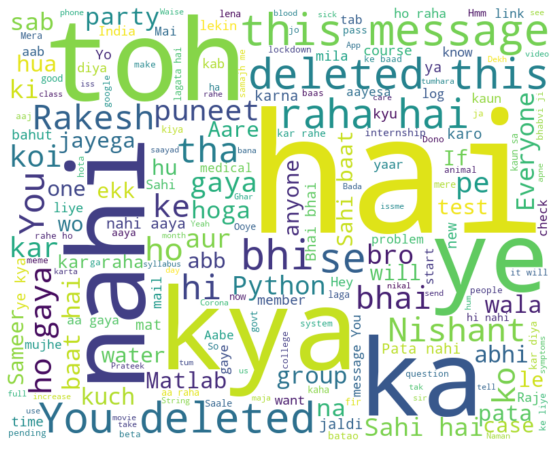

Word Cloud for Raj Ranjan(Iiitg):
---------------------------------------


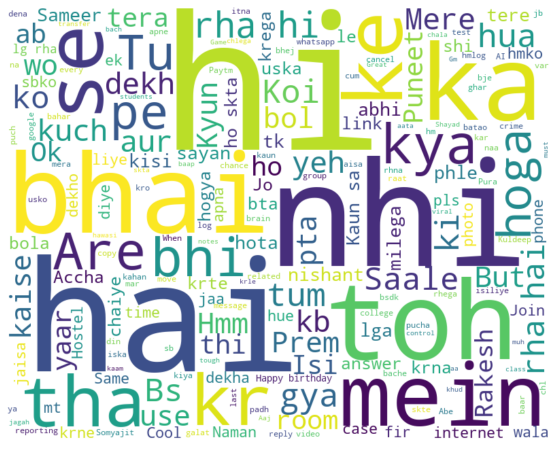

Word Cloud for Rakesh(Iiitg):
---------------------------------------


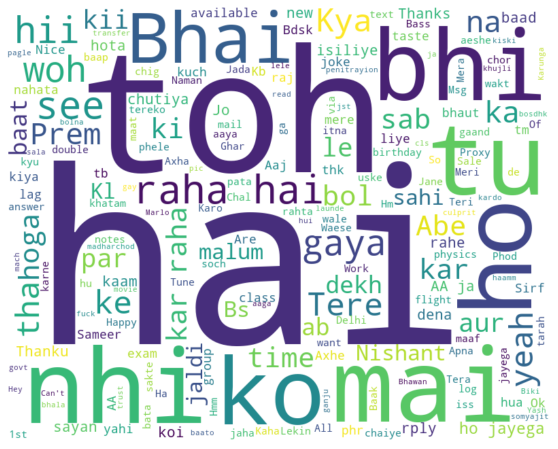

Word Cloud for Sayan(Iiitg):
---------------------------------------


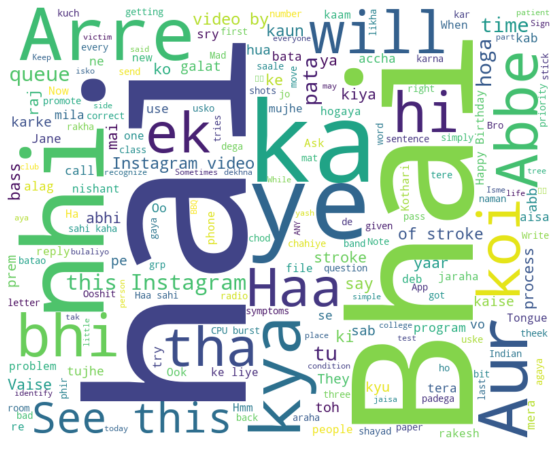

Word Cloud for Nishant(Iiitg):
---------------------------------------


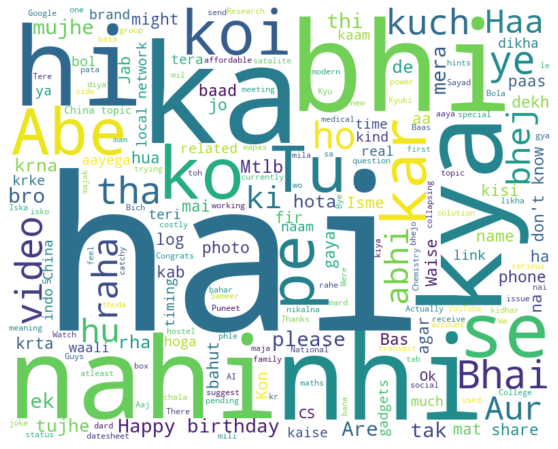

Word Cloud for Yash Kothari(Iiitg):
---------------------------------------


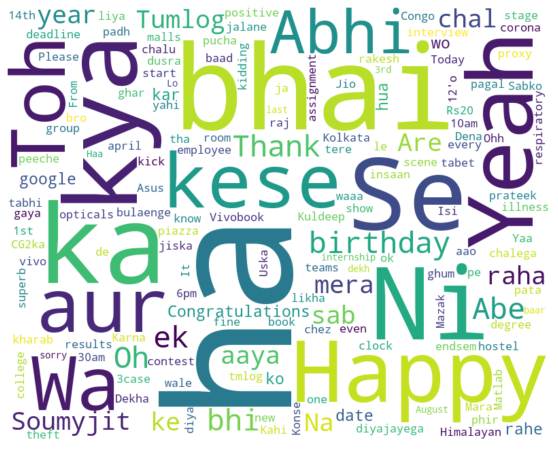

Word Cloud for Soumyajit(Iiitg):
---------------------------------------


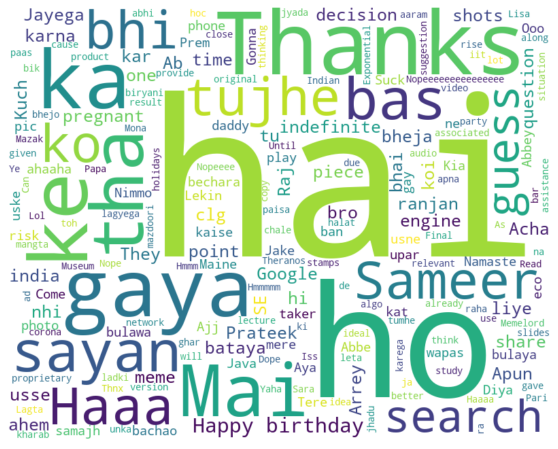

Word Cloud for Naman Gera(Iiitg):
---------------------------------------


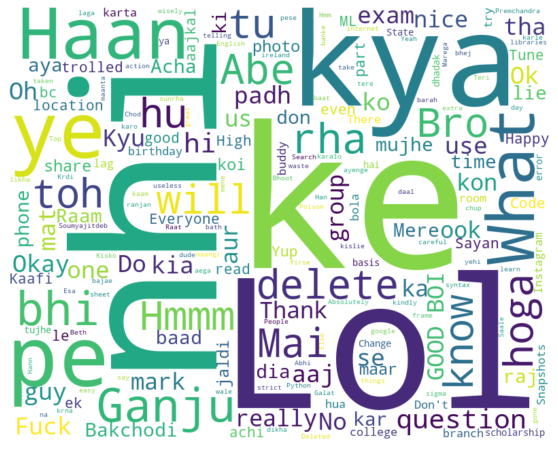

Word Cloud for Puneet(Iiitg):
---------------------------------------


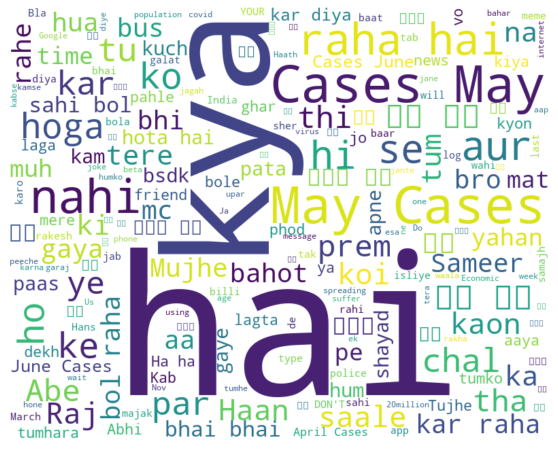

Word Cloud for Sameer(Iiitg):
---------------------------------------


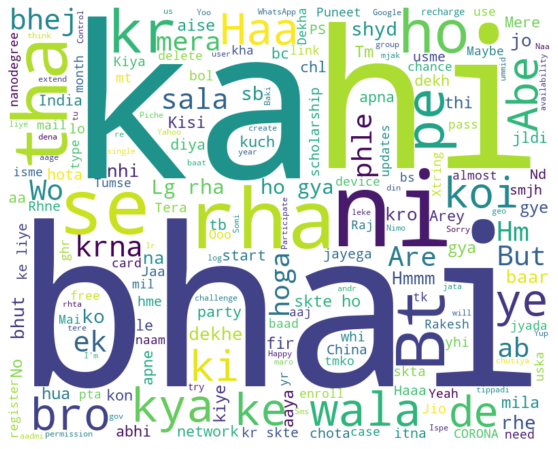

Word Cloud for Prateek(Iiitg):
---------------------------------------


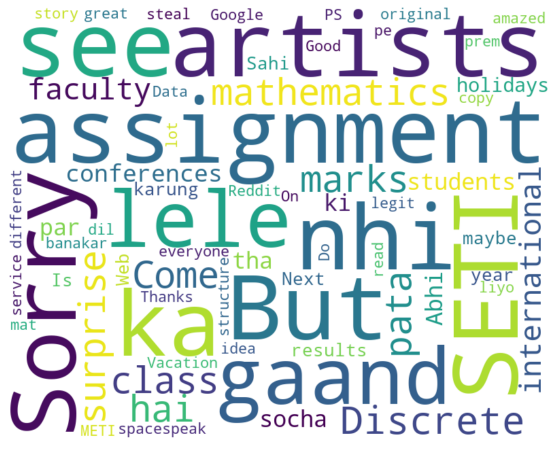

Word Cloud for Roshan(Iiitg):
---------------------------------------


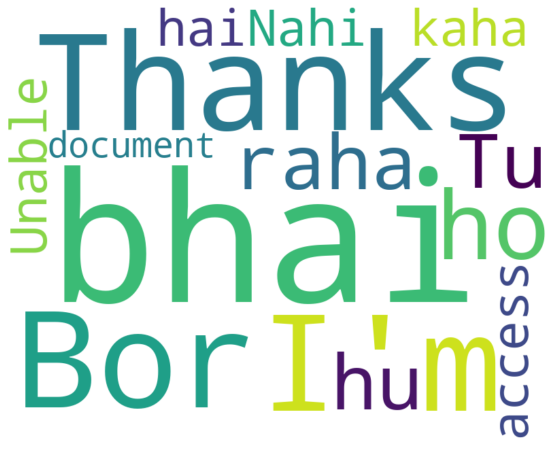

Word Cloud for Tushar(Iiitg):
---------------------------------------


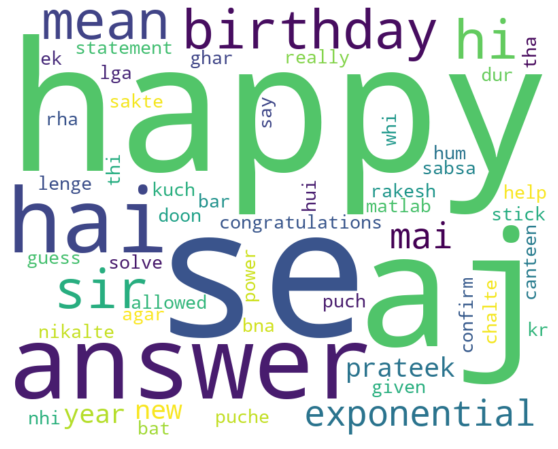

In [22]:
names = authors_name(data)

for each in names:
    print('Word Cloud for {}:'.format(each))
    print('---------------------------------------')
    df = data[data['Author'] == each]
    word_cloud(df)

### Happening Day (Active for chat)

Text(0, 0.5, 'Date')

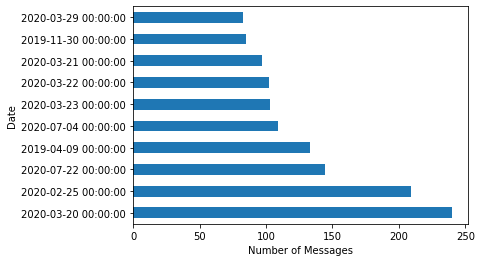

In [23]:
data['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### Active for chat

Text(0, 0.5, 'Time')

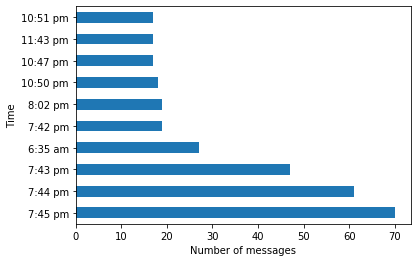

In [24]:
# Top 10 Time of the day at which the most number of messages were sent
data['Time'].value_counts().head(10).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Time')

### Day wise distribution of messages

In [25]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

day_df = pd.DataFrame(data["Message"])
day_df['day_of_date'] = data['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(lambda d: days[d])
day_df["messagecount"] = 1

day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [26]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### Number of messages as times move on¶

In [27]:
data['MessageCount'] = 1

In [28]:
date_df = data.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

### Chatter

In [29]:
auth = data.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

Analysis completed, moving towards making WebApp.